# Image Convolution and Deconvolution based on FFT

This notebook display the convolution and deconvolution process through the FFT.
The deconvolution process uses the Richarson-Lucy algorithm for image deconvolution adapted from the [clij2-fft](https://github.com/clij/clij2-fft/tree/master) repository.

In [1]:
import pyclesperanto as cle
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt

cle.select_device(1,"gpu")

(OpenCL) Apple M2 Max (OpenCL 1.2 )
	Vendor:                      Apple
	Driver Version:              1.2 1.0
	Device Type:                 GPU
	Compute Units:               30
	Global Memory Size:          21845 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         4096 MB
	Max Clock Frequency:         1000 MHz
	Image Support:               Yes

## Load images, psf, and ground truth

We will demonstrate the pipeline using artificial data, two images with and without noise, a psf image, and a ground truth for comparison.

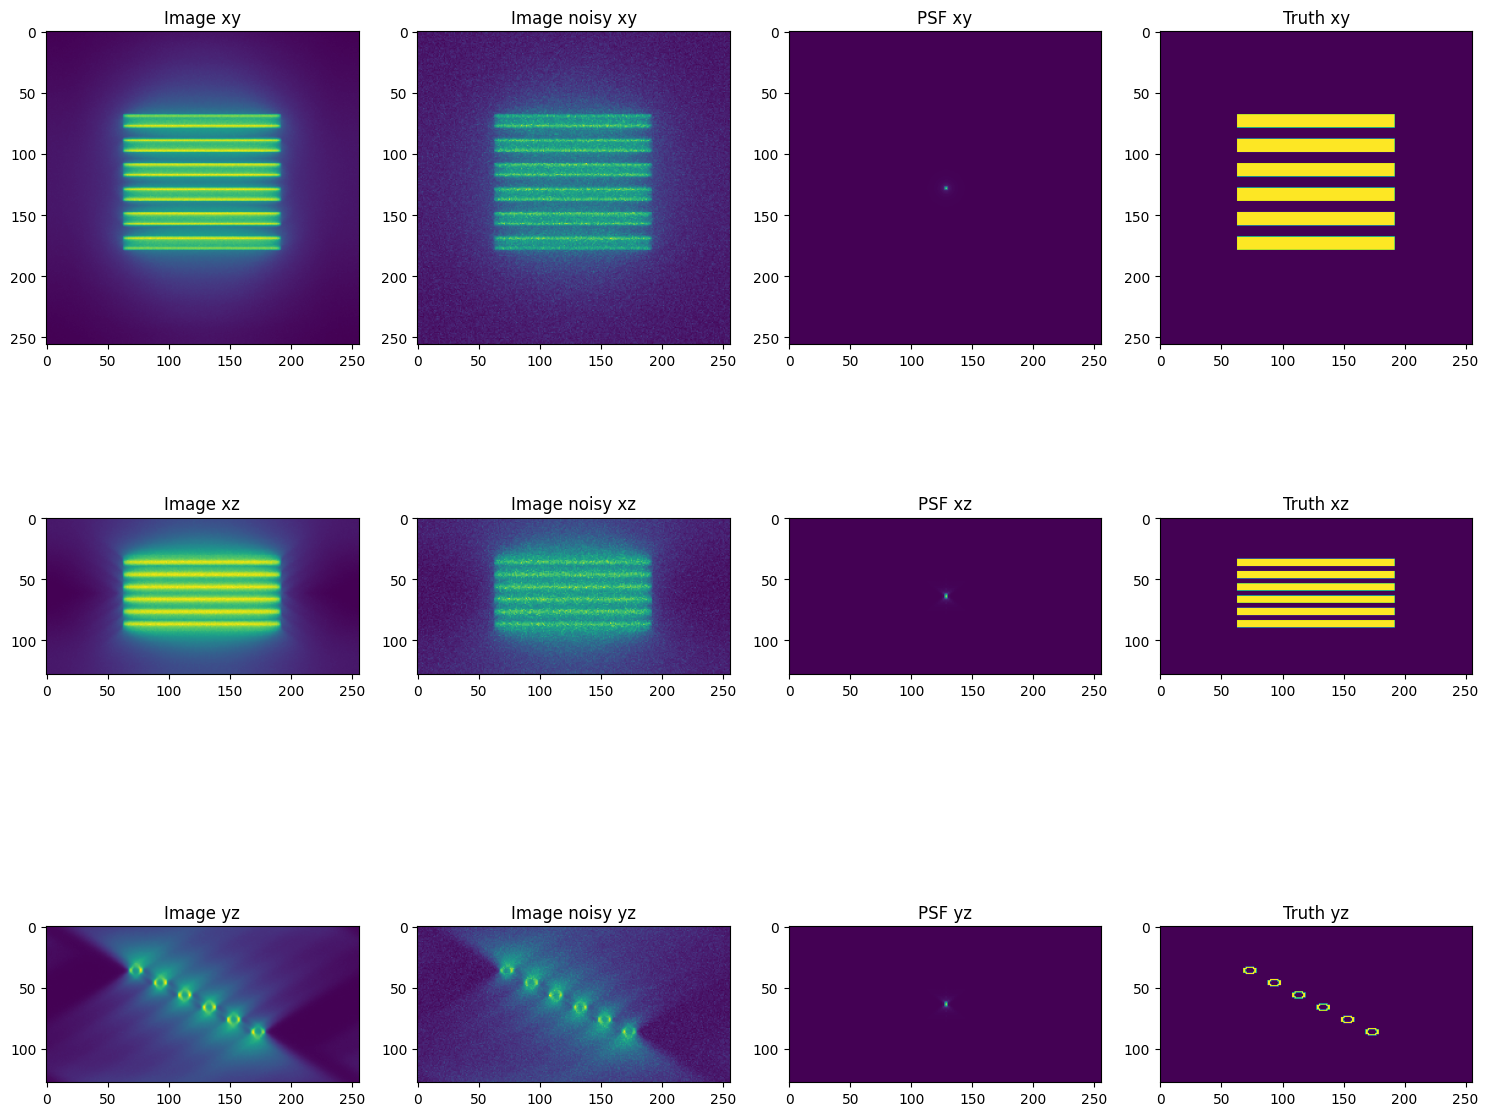

In [8]:
data_folder = '../data/deconv'
im_name = 'Bars-G10-P30-stack.tif'
im_name_noise = 'Bars-G10-P15-stack.tif'
psf_name = 'PSF-Bars-stack.tif'
truth_name = 'Bars-stack.tif'

im = imread(data_folder + '/' + im_name).astype(np.float32)
im_noise = imread(data_folder + '/' + im_name_noise).astype(np.float32)
psf = imread(data_folder + '/' + psf_name).astype(np.float32)
truth = imread(data_folder + '/' + truth_name).astype(np.float32)

# plot the image, psf and ground truth in a subplot
fig, axs = plt.subplots(3,4, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im.max(axis=0))
ax[0].set_title('Image xy')
ax[4].imshow(im.max(axis=1))
ax[4].set_title('Image xz')
ax[8].imshow(im.max(axis=2))
ax[8].set_title('Image yz')

ax[1].imshow(im_noise.max(axis=0))
ax[1].set_title('Image noisy xy')
ax[5].imshow(im_noise.max(axis=1))
ax[5].set_title('Image noisy xz')
ax[9].imshow(im_noise.max(axis=2))
ax[9].set_title('Image noisy yz')

ax[2].imshow(psf.max(axis=0))
ax[2].set_title('PSF xy')
ax[6].imshow(psf.max(axis=1))
ax[6].set_title('PSF xz')
ax[10].imshow(psf.max(axis=2))
ax[10].set_title('PSF yz')

ax[3].imshow(truth.max(axis=0))
ax[3].set_title('Truth xy')
ax[7].imshow(truth.max(axis=1))
ax[7].set_title('Truth xz')
ax[11].imshow(truth.max(axis=2))
ax[11].set_title('Truth yz')

plt.tight_layout()
plt.show()

## Convolution operation

We can see how the convolution process works by convoluting a `truth` sample with a `psf` kernel. This operation would be similar to the observation of a sample under a microscope. We could also use this pipeline for classic image analysis convolution but in the frequencial domain.

The convolution using FFT have a set of requirements, mainly:
- the `psf` kernel must be padded to the same size of the image to proces
- the `psf` center point must be set at `(0,0,0)`

The `convolve_fft` will take care to padd the `psf` to the correct size and apply a `circular_shift` of the data to center it correctly for the operation.

Let's first test to apply a convolution between two arrays.

In [10]:
# Create an example input image
input_np = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=np.float32)

# Create a kernel (e.g., 3x3 averaging filter)
kernel_np = np.ones((3,3), dtype=np.float32)

# Convert to GPU arrays
input_gpu = cle.push(input_np)
kernel_gpu = cle.push(kernel_np)

# Call _convolution (not typically recommended)
output_gpu = cle.convolve_fft(input_gpu, kernel_gpu, None, correlate=False)

# Retrieve result
output_np = cle.pull(output_gpu)
print(output_np)

[[36. 36. 36.]
 [36. 36. 36.]
 [36. 36. 36.]]


Let's see the same kernel (a bit bigger, 10x10) but this time on an example image

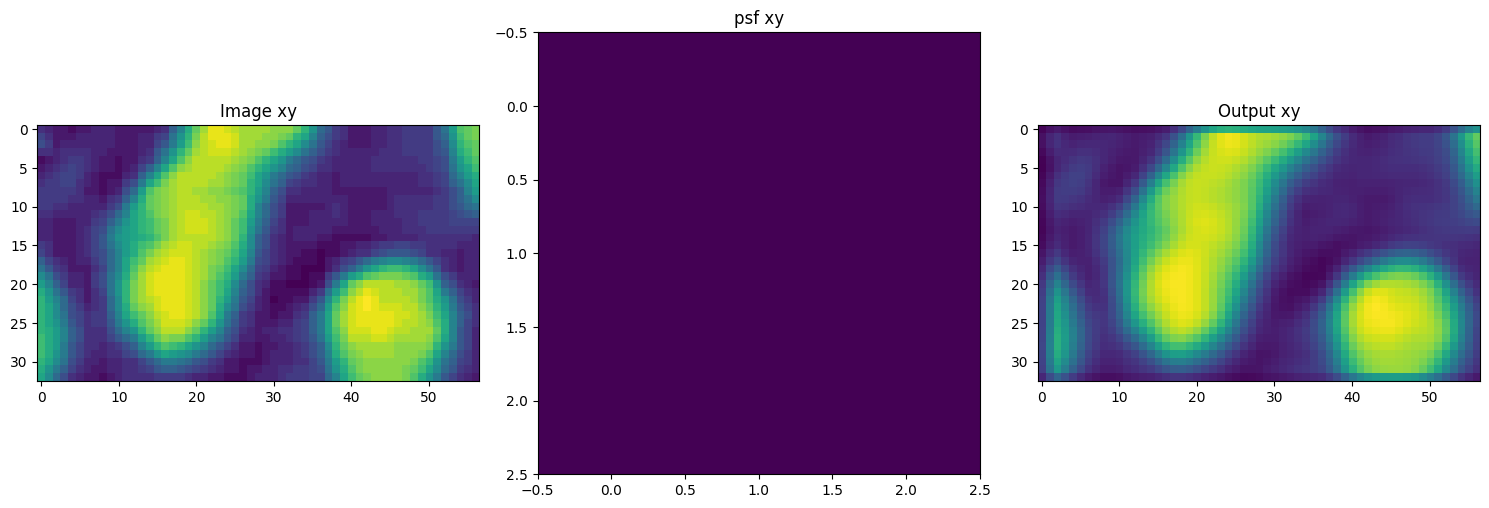

In [11]:
image = cle.push(imread("https://samples.fiji.sc/blobs.png").squeeze().astype(np.float32)[:33,:57])

kernel_np = np.ones((3,3), dtype=np.float32) / 9
kernel_gpu = cle.push(kernel_np)

# output_gpu = cle.create_like(image)
output_gpu = cle.convolve_fft(image, kernel_gpu, None, correlate=False)
output_np = cle.pull(output_gpu)

fig, axs = plt.subplots(1,3, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(cle.pull(image))
ax[0].set_title('Image xy')

ax[1].imshow(cle.pull(kernel_np))
ax[1].set_title('psf xy')

ax[2].imshow(cle.pull(output_gpu))
ax[2].set_title('Output xy')

plt.tight_layout()
plt.show()

We applied a classical `mean_filter` throug the frequential domain.

If this time, instead of a mathematical kernel we use a `psf` similar to a microscope `psf`, we can replicate the optical effect of the 

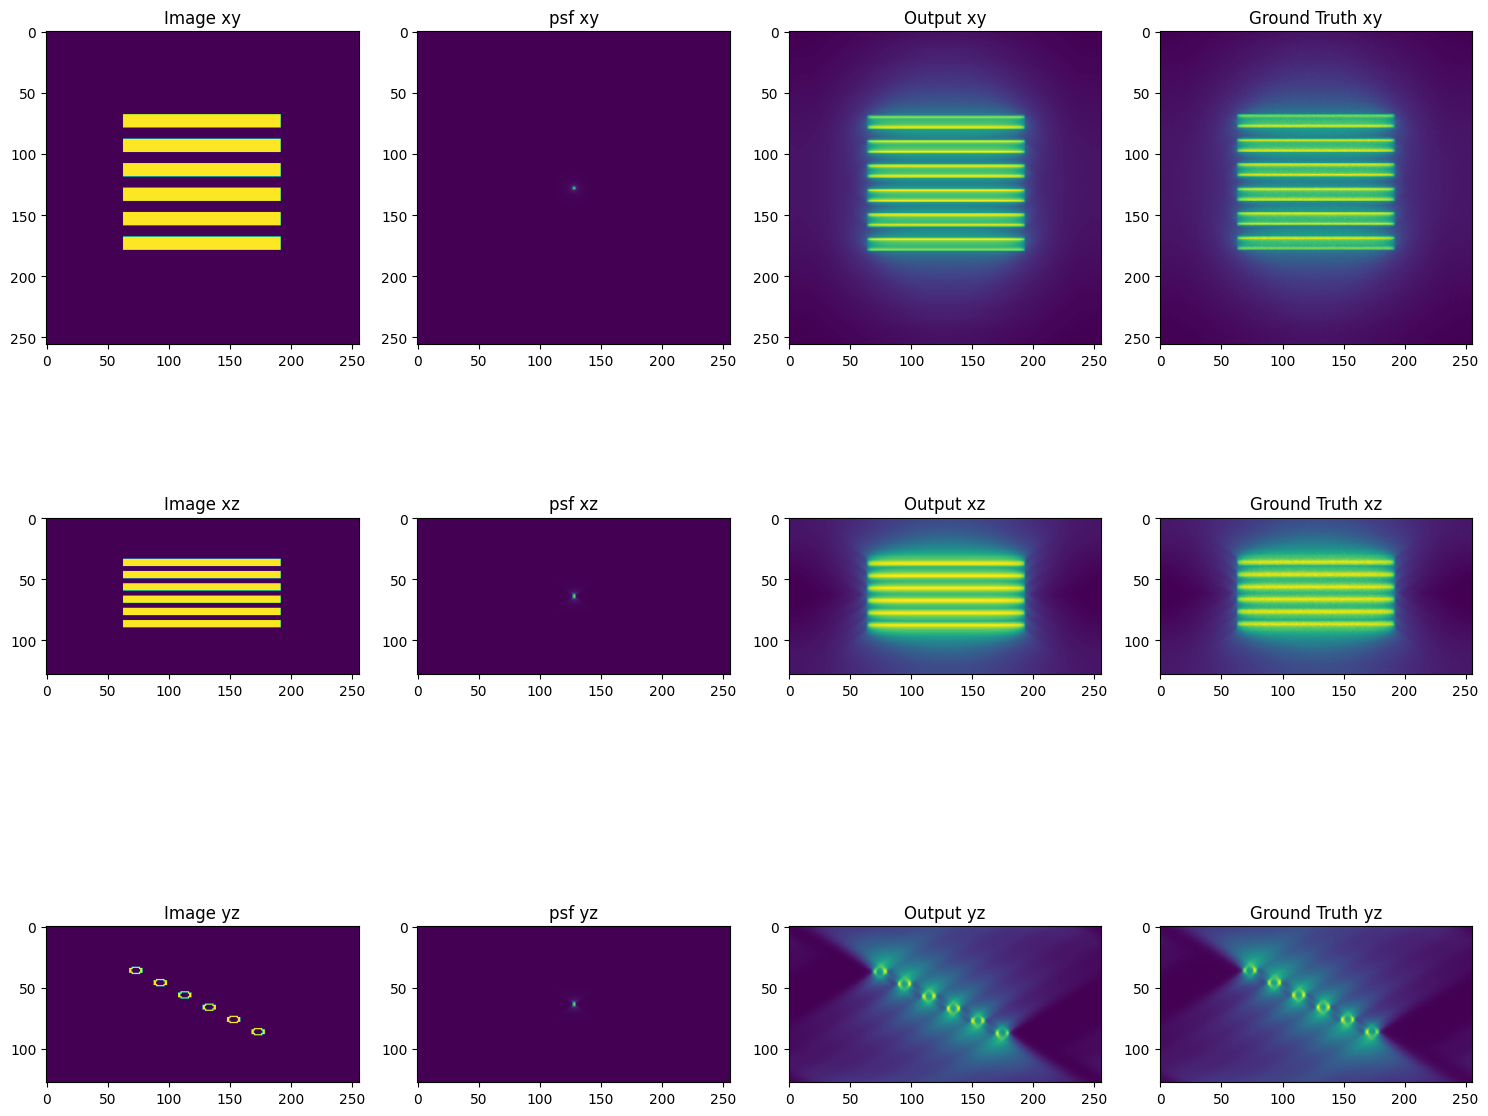

In [12]:
# Convert to GPU arrays
input_gpu = cle.push(truth)
kernel_gpu = cle.push(psf)

# Call the convolution operation
output_gpu = cle.convolve_fft(input_gpu, kernel_gpu, None, correlate=False)
output_np = cle.pull(output_gpu)

fig, axs = plt.subplots(3,4, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(truth.max(axis=0))
ax[0].set_title('Image xy')
ax[4].imshow(truth.max(axis=1))
ax[4].set_title('Image xz')
ax[8].imshow(truth.max(axis=2))
ax[8].set_title('Image yz')

ax[1].imshow(psf.max(axis=0))
ax[1].set_title('psf xy')
ax[5].imshow(psf.max(axis=1))
ax[5].set_title('psf xz')
ax[9].imshow(psf.max(axis=2))
ax[9].set_title('psf yz')

ax[2].imshow(output_np.max(axis=0))
ax[2].set_title('Output xy')
ax[6].imshow(output_np.max(axis=1))
ax[6].set_title('Output xz')
ax[10].imshow(output_np.max(axis=2))
ax[10].set_title('Output yz')

ax[3].imshow(im.max(axis=0))
ax[3].set_title('Ground Truth xy')
ax[7].imshow(im.max(axis=1))
ax[7].set_title('Ground Truth xz')
ax[11].imshow(im.max(axis=2))
ax[11].set_title('Ground Truth yz')

plt.tight_layout()
plt.show()

## Deconvolution

The deconvolution is the inverse process of the convolution. 

We can use it here to reconstruct the original image from a microscope, if we know the microscope `psf`. Here we show two example, with and without a regularization factor on our test data. 

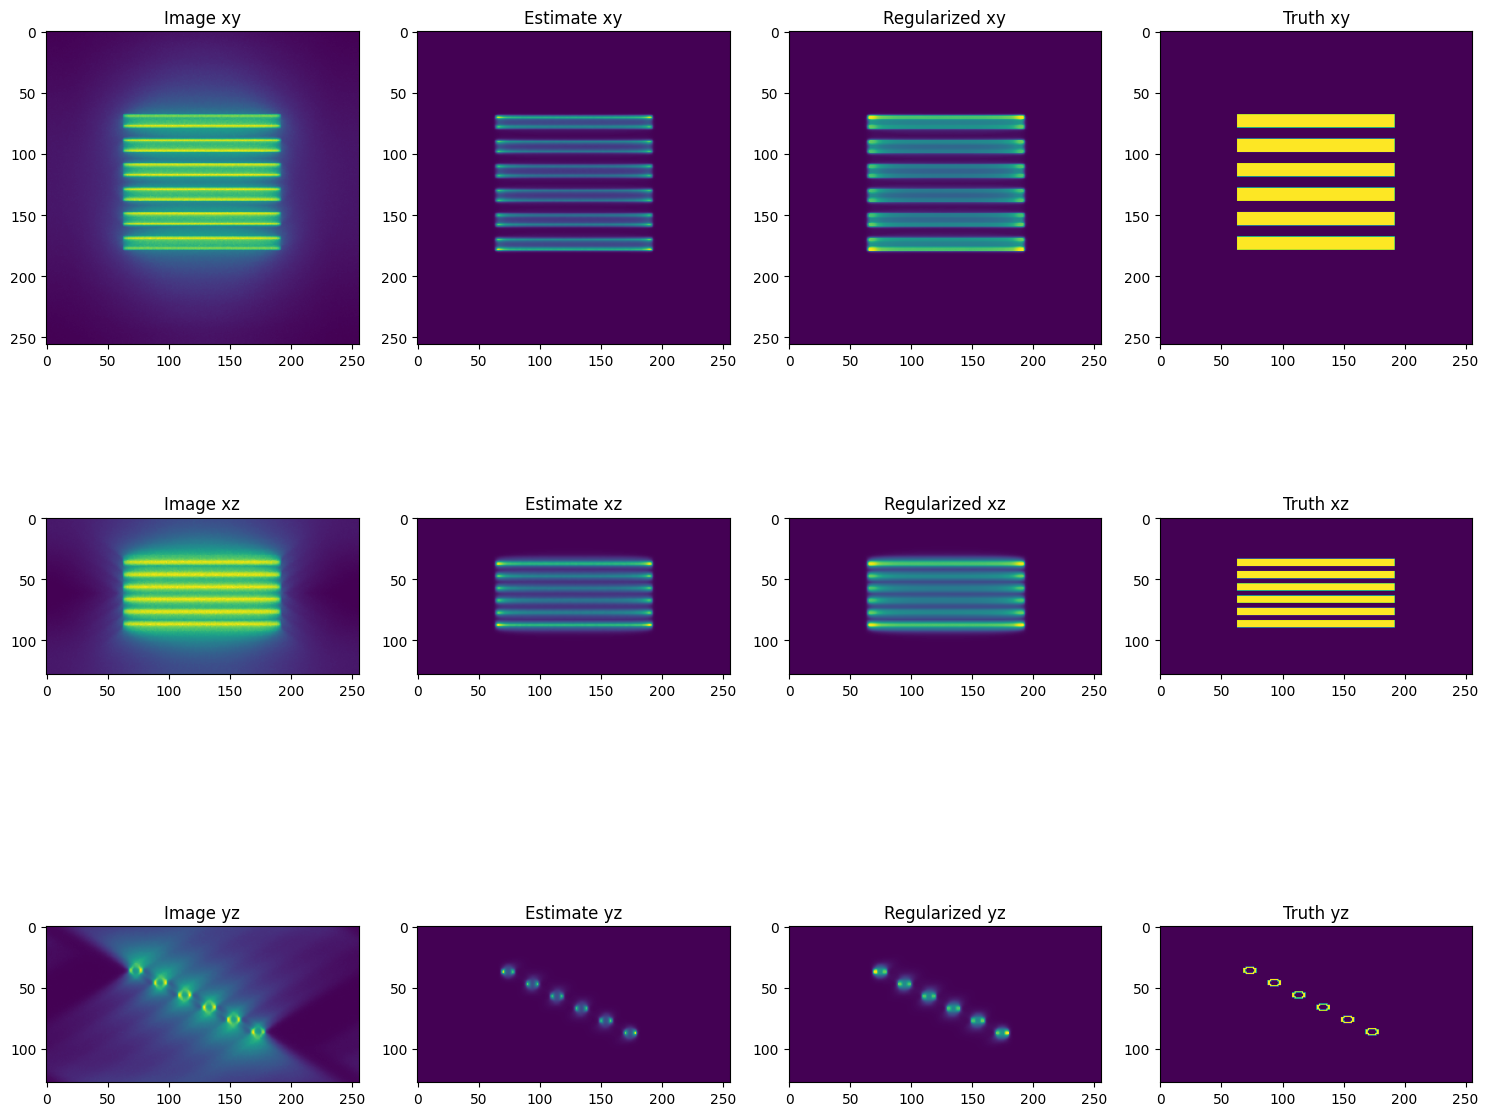

In [13]:
# deconvolution
input_gpu = cle.push(im)
kernel_gpu = cle.push(psf)

output_gpu = cle.deconvolve_fft(input_gpu, kernel_gpu, None, None, 100, 0)
output_gpu_reg = cle.deconvolve_fft(input_gpu, kernel_gpu, None, None, 100, 0.004)
out = cle.pull(output_gpu)
out_reg = cle.pull(output_gpu_reg)


fig, axs = plt.subplots(3,4, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im.max(axis=0))
ax[0].set_title('Image xy')
ax[4].imshow(im.max(axis=1))
ax[4].set_title('Image xz')
ax[8].imshow(im.max(axis=2))
ax[8].set_title('Image yz')

ax[1].imshow(out.max(axis=0))
ax[1].set_title('Estimate xy')
ax[5].imshow(out.max(axis=1))
ax[5].set_title('Estimate xz')
ax[9].imshow(out.max(axis=2))
ax[9].set_title('Estimate yz')

ax[2].imshow(out_reg.max(axis=0))
ax[2].set_title('Regularized xy')
ax[6].imshow(out_reg.max(axis=1))
ax[6].set_title('Regularized xz')
ax[10].imshow(out_reg.max(axis=2))
ax[10].set_title('Regularized yz')

ax[3].imshow(truth.max(axis=0))
ax[3].set_title('Truth xy')
ax[7].imshow(truth.max(axis=1))
ax[7].set_title('Truth xz')
ax[11].imshow(truth.max(axis=2))
ax[11].set_title('Truth yz')

plt.tight_layout()
plt.show()

The regularization factor aim to improve the smoothness of the estimated output, principally usefull for noisy data

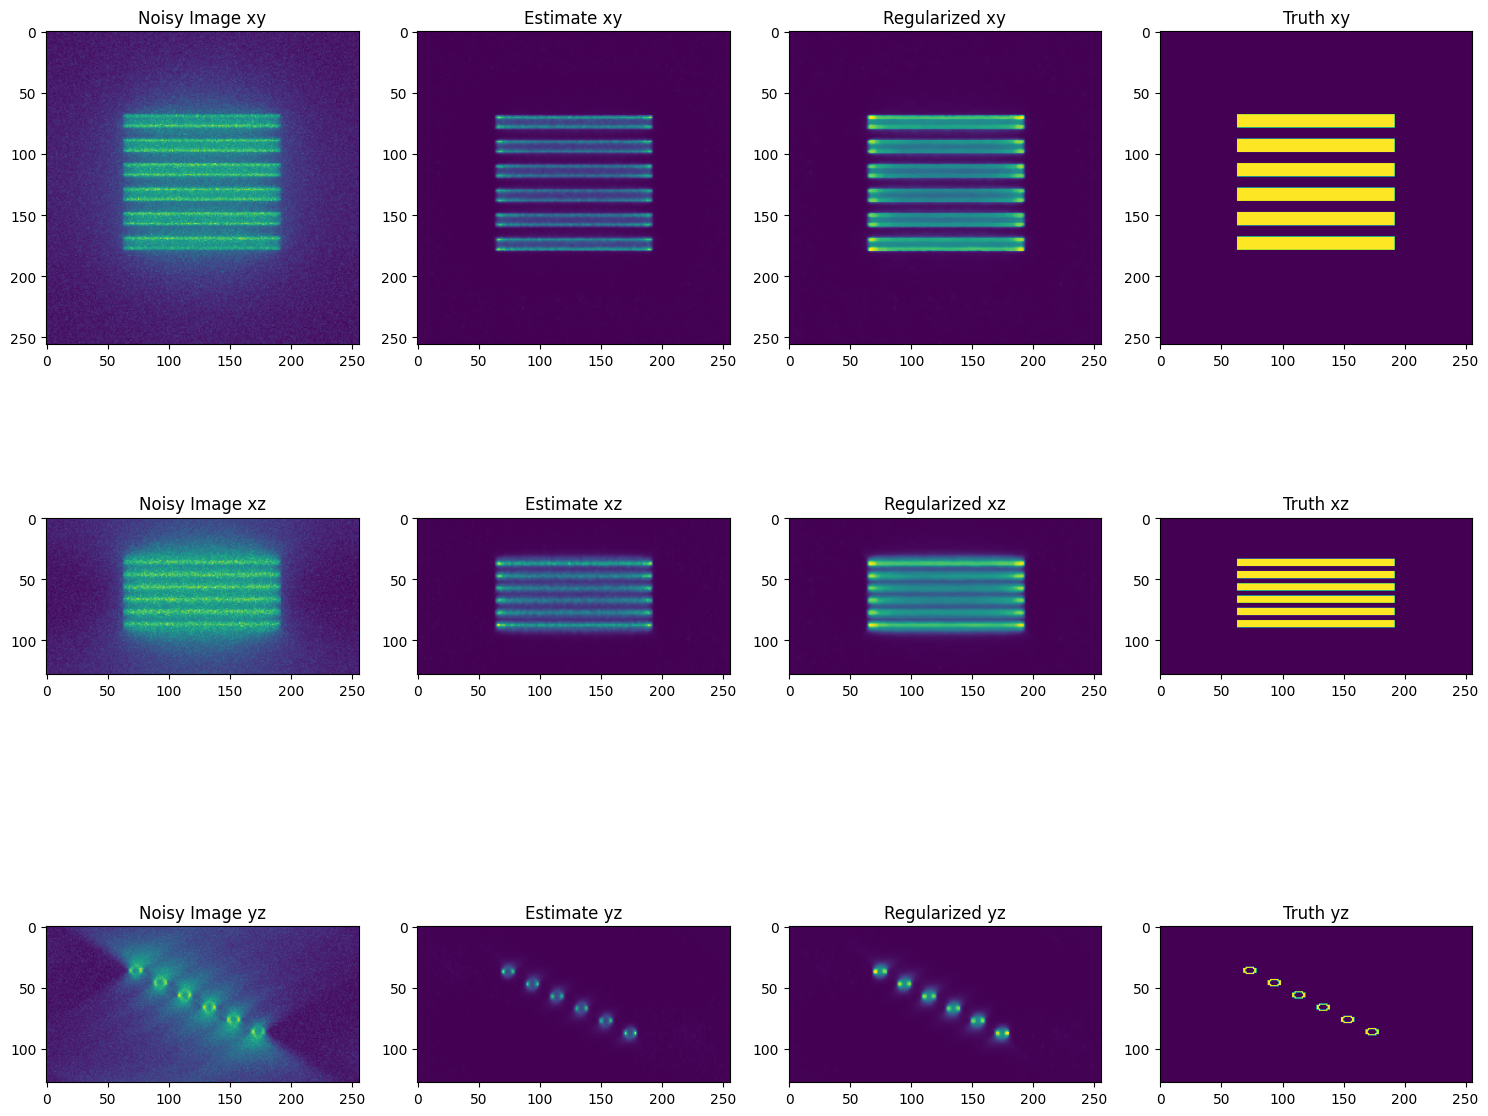

In [14]:
# deconvolution
input_gpu = cle.push(im_noise)
kernel_gpu = cle.push(psf)

output_gpu = cle.deconvolve_fft(input_gpu, kernel_gpu, None, None, 100, 0)
output_gpu_reg = cle.deconvolve_fft(input_gpu, kernel_gpu, None, None, 100, 0.004)
out = cle.pull(output_gpu)
out_reg = cle.pull(output_gpu_reg)


fig, axs = plt.subplots(3,4, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im_noise.max(axis=0))
ax[0].set_title('Noisy Image xy')
ax[4].imshow(im_noise.max(axis=1))
ax[4].set_title('Noisy Image xz')
ax[8].imshow(im_noise.max(axis=2))
ax[8].set_title('Noisy Image yz')

ax[1].imshow(out.max(axis=0))
ax[1].set_title('Estimate xy')
ax[5].imshow(out.max(axis=1))
ax[5].set_title('Estimate xz')
ax[9].imshow(out.max(axis=2))
ax[9].set_title('Estimate yz')

ax[2].imshow(out_reg.max(axis=0))
ax[2].set_title('Regularized xy')
ax[6].imshow(out_reg.max(axis=1))
ax[6].set_title('Regularized xz')
ax[10].imshow(out_reg.max(axis=2))
ax[10].set_title('Regularized yz')

ax[3].imshow(truth.max(axis=0))
ax[3].set_title('Truth xy')
ax[7].imshow(truth.max(axis=1))
ax[7].set_title('Truth xz')
ax[11].imshow(truth.max(axis=2))
ax[11].set_title('Truth yz')

plt.tight_layout()
plt.show()